<div class="alert alert-block alert-info">
<b>Number of points for this notebook:</b> 0
<br>
<b>Deadline:</b> February 4, 2026 (Wednesday) 23:59
</div>

# Exercise 1. Regularization techniques

This is a simple exercise, in which we will try a few methods to prevent overfitting.

## Learning goals:
* Understand various methods to prevent overfitting of neural networks.
* Experience in using regularization methods in pytorch.

In [1]:
skip_training = True  # Set this flag to True before validation and submission

In [2]:
# During evaluation, this cell sets skip_training to True
# skip_training = True

import tools, warnings
warnings.showwarning = tools.customwarn

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

import tools

In [4]:
# Select device which you are going to use for training
device = torch.device("cpu")

In [5]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device("cpu")

## Regression problem
We will look at a regression problem where the task is to estimate a function of one variable
$$y = f(x)$$
using a set of training examples $(x_1, y_1), \ldots, (x_n, y_n)$.

Let us first generate training examples $y_i=\sin(x_i) + n_i$ with $x_i$ drawn from the uniform distribution in $[-0.5, 0.5]$ and noise $n_i$ drawn from the Gaussian distribution.

In [6]:
np.random.seed(1)
n = 80
x = np.random.rand(n, 1)-0.5

def fun(x):
    y = np.cos(2* np.pi * x)
    y += 0.3 * np.random.randn(*x.shape)
    return y

y = fun(x)

# Convert to PyTorch tensors
x = torch.tensor(x).float()
y = torch.tensor(y).float()

Let us split the data into training, validation and test sets and plot the training and validation sets. And let us plot the data.

In [7]:
# Split the data into training and test sets
torch.manual_seed(2)
rp = torch.randperm(x.size(0))

n_train = int(x.size(0) * 0.8)
x_train, y_train = x[rp[:n_train]], y[rp[:n_train]]
x_test, y_test = x[rp[n_train:]], y[rp[n_train:]]

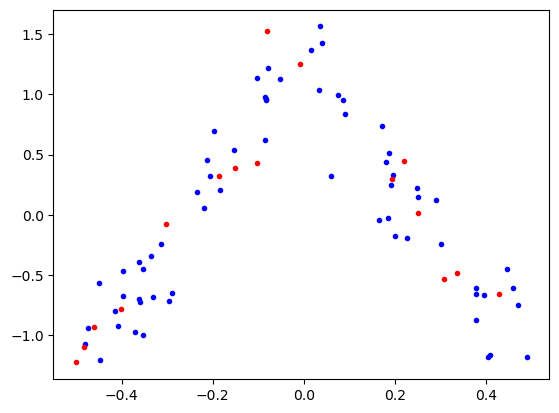

In [8]:
# Plot the data
fix, ax = plt.subplots(1)
ax.plot(x_train, y_train, 'b.')
ax.plot(x_test, y_test, 'r.')

## Define a multi-layer perceptron (MLP) network with two hidden layers

In the code below, we define a neural network architecture with:
* input dimension 1
* one hidden layer with 100 units with tanh nonlinearity
* one hidden layer with 100 units with tanh nonlinearity
* linear output layer with output dimension 1

In [15]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP,self).__init__()
        self.fc1=nn.Linear(1,100)
        self.fc2=nn.Linear(100,100)
        self.fc3=nn.Linear(100,1)

    def forward(self, x):
        out=F.tanh(self.fc1(x))
        out=F.tanh(self.fc2(out))
        return self.fc3(out)

In [16]:
# Create an MLP network
mlp = MLP()
mlp.to(device)

MLP(
  (fc1): Linear(in_features=1, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1, bias=True)
)

In [17]:
# This visualizes the function implemented by an MLP
def plot_fit(mlp, x_train, y_train):
    fig, ax = plt.subplots(1)
    ax.plot(x_train, y_train, '.')
    x_np = np.linspace(-0.5, 0.5, 100).reshape((-1, 1))
    x = torch.tensor(x_np, device=device, dtype=torch.float)
    pred = mlp.forward(x).cpu().data.numpy()
    ax.plot(x_np, pred)

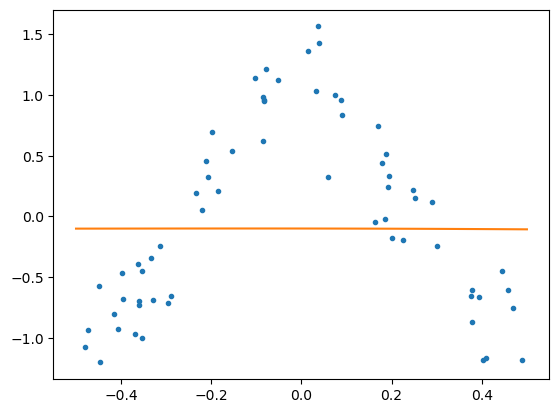

In [18]:
# Plot the function implemented by the MLP
plot_fit(mlp, x_train, y_train)

In [19]:
# This is the function to compute the loss:
def compute_loss(mlp, x, y):
    mlp.eval()
    with torch.no_grad():
        outputs = mlp.forward(x)
        loss = F.mse_loss(outputs, y)
        return loss.cpu().numpy()

# This is the function to print the progress during training
def print_progress(epoch, train_error, val_error):
    print('Epoch {}: Train error: {:.4f}, Test error: {:.4f}'.format(
        epoch, train_error, val_error))

## Train the MLP network without regularization
Training is done by minimizing the mean-squared error computed on the training data:
$$c=\sum_{i=1}^n || f(x_i) - y_i ||^2.$$

Here, we train the network:
* using all the data for computing the gradient (batch mode)
* using `n_epochs` epochs (which is equal to the number of parameter updates in the batch mode).

In [20]:
mlp = MLP()
mlp.to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.01)

In [21]:
if not skip_training:
    n_epochs = 10000
    train_errors = []  # Keep track of the training data
    val_errors = []  # Keep track of the validation data
    x = x_train.to(device)
    y = y_train.to(device)
    for epoch in range(n_epochs):

        optimizer.zero_grad()
        outputs = mlp.forward(x)
        loss = F.mse_loss(outputs, y)
        loss.backward()
        optimizer.step()

        if (epoch+1) % 500 == 0:
            train_errors.append(compute_loss(mlp, x_train, y_train))
            val_errors.append(compute_loss(mlp, x_test, y_test))
            print_progress(epoch, train_errors[-1], val_errors[-1])

    # Save the model to disk (the pth-files will be submitted automatically together with your notebook)
    tools.save_model(mlp, 'mlp_noreg.pth', confirm=False)
else:
    mlp = MLP()
    tools.load_model(mlp, 'mlp_noreg.pth', device)

Epoch 499: Train error: 0.0588, Test error: 0.0692
Epoch 999: Train error: 0.0560, Test error: 0.0728
Epoch 1499: Train error: 0.0499, Test error: 0.0841
Epoch 1999: Train error: 0.0397, Test error: 0.0829
Epoch 2499: Train error: 0.0305, Test error: 0.0966
Epoch 2999: Train error: 0.0272, Test error: 0.1135
Epoch 3499: Train error: 0.0244, Test error: 0.1234
Epoch 3999: Train error: 0.0238, Test error: 0.1293
Epoch 4499: Train error: 0.0253, Test error: 0.1235
Epoch 4999: Train error: 0.0182, Test error: 0.1145
Epoch 5499: Train error: 0.0166, Test error: 0.1113
Epoch 5999: Train error: 0.0152, Test error: 0.1053
Epoch 6499: Train error: 0.0148, Test error: 0.1036
Epoch 6999: Train error: 0.0146, Test error: 0.1096
Epoch 7499: Train error: 0.0164, Test error: 0.1130
Epoch 7999: Train error: 0.0140, Test error: 0.0994
Epoch 8499: Train error: 0.0129, Test error: 0.1029
Epoch 8999: Train error: 0.0107, Test error: 0.1244
Epoch 9499: Train error: 0.0091, Test error: 0.1361
Epoch 9999: Tr

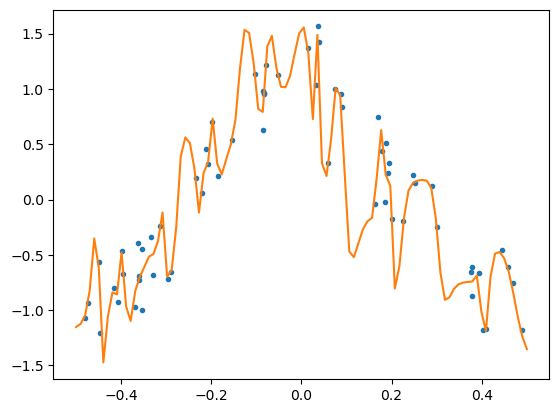

In [22]:
# Plot the final fit
plot_fit(mlp, x_train, y_train)

As you can see, the network overfits to the training data.

In [23]:
test_loss_no_regularization = compute_loss(mlp, x_test, y_test)
print("Test loss without regularization: %.5f" % test_loss_no_regularization)

Test loss without regularization: 0.14255


Let us look at the learning curves (the evolution of training and test errors during training).

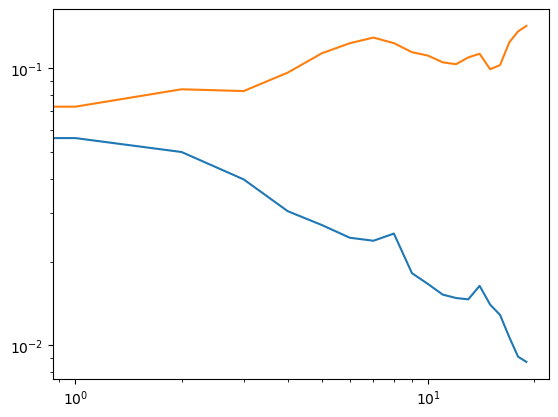

In [24]:
if not skip_training:
    fig, ax = plt.subplots(1)
    ax.loglog(train_errors)
    ax.loglog(val_errors)

 As you can see, the test error first decreases and then starts growing. This motivates the following technique to prevent overfitting.

## Early stopping

In early stopping, we stop training when the test error (or validation error) starts growing.

In the code below, we define a stopping creterion in function `stop_criterion`. Training is stopped (function returns  `True`) when the validation error is larger than the best validation error obtained so far (with given `tolerance`) for `patience` epochs.

In [25]:
class EarlyStopping:
    def __init__(self, tolerance, patience):
        """
        Args:
          patience (int):    Maximum number of epochs with unsuccessful updates.
          tolerance (float): We assume that the update is unsuccessful if the validation error is larger
                              than the best validation error so far plus this tolerance.
        """
        self.tolerance = tolerance
        self.patience = patience

    def stop_criterion(self, val_errors):
        """
        Args:
          val_errors (iterable): Validation errors after every update during training.

        Returns: True if training should be stopped: when the validation error is larger than the best
                  validation error obtained so far (with given tolearance) for patience epochs (number of consecutive epochs for which the criterion is satisfied).

                 Otherwise, False.
        """
        if len(val_errors) <= self.patience:
            return False

        min_val_error = min(val_errors)
        val_errors = np.array(val_errors[-self.patience:])
        return all(val_errors > min_val_error + self.tolerance)

In [36]:
mlp = MLP()
mlp.to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)

In [27]:
# Train the network with early stopping
if not skip_training:
    n_epochs = 10000
    train_errors = []  # Keep track of the training error
    val_errors = []  # Keep track of the validation error
    early_stop = EarlyStopping(tolerance=0.01, patience=20)

    x = x_train.to(device)
    y = y_train.to(device)

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        outputs = mlp.forward(x)
        loss = F.mse_loss(outputs, y)
        loss.backward()
        optimizer.step()

        train_errors.append(compute_loss(mlp, x_train, y_train))
        val_errors.append(compute_loss(mlp, x_test, y_test))

        if early_stop.stop_criterion(val_errors):
            print(val_errors[epoch])
            print('Stop after %d epochs' % epoch)
            break

        if (epoch+1) % 100 == 0:
            print_progress(epoch, train_errors[epoch], val_errors[epoch])

    # Save the model to disk (the pth-files will be submitted automatically together with your notebook)
    tools.save_model(mlp, 'mlp_early.pth', confirm=False)
else:
    mlp = MLP()
    tools.load_model(mlp, 'mlp_early.pth', device)

Epoch 99: Train error: 0.0833, Test error: 0.0612
Epoch 199: Train error: 0.0662, Test error: 0.0562
Epoch 299: Train error: 0.0660, Test error: 0.0582
Epoch 399: Train error: 0.0661, Test error: 0.0590
Epoch 499: Train error: 0.0659, Test error: 0.0594
Epoch 599: Train error: 0.0659, Test error: 0.0598
Epoch 699: Train error: 0.0658, Test error: 0.0599
Epoch 799: Train error: 0.0657, Test error: 0.0602
Epoch 899: Train error: 0.0656, Test error: 0.0605
Epoch 999: Train error: 0.0654, Test error: 0.0609
Epoch 1099: Train error: 0.0651, Test error: 0.0614
Epoch 1199: Train error: 0.0647, Test error: 0.0619
Epoch 1299: Train error: 0.0642, Test error: 0.0625
Epoch 1399: Train error: 0.0634, Test error: 0.0627
Epoch 1499: Train error: 0.0621, Test error: 0.0624
Epoch 1599: Train error: 0.0604, Test error: 0.0617
Epoch 1699: Train error: 0.0585, Test error: 0.0621
Epoch 1799: Train error: 0.0575, Test error: 0.0639
0.06393947
Stop after 1801 epochs
Model saved to mlp_early.pth.


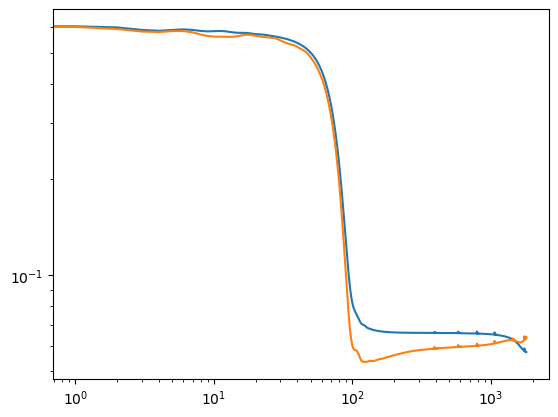

In [28]:
# Plot the learning curves
if not skip_training:
    fig, ax = plt.subplots(1)
    ax.loglog(train_errors)
    ax.loglog(val_errors)

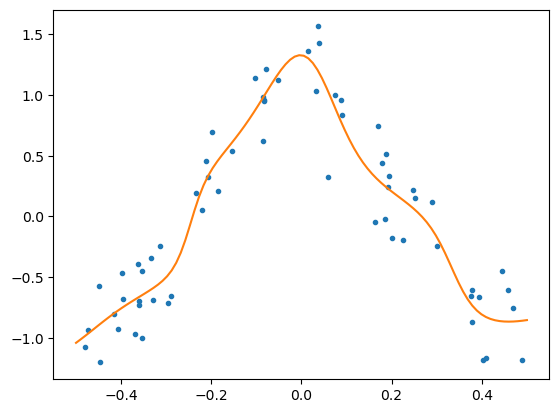

In [29]:
# Plot the final fit
plot_fit(mlp, x_train, y_train)

In [30]:
test_loss_early_stopping = compute_loss(mlp, x_test, y_test)
print("Test loss with early stopping: %.5f" % test_loss_early_stopping)

Test loss with early stopping: 0.06394


## Weight-decay regularization

Let us train the same network with L2 penalties on the weights. In PyTorch, one can add L2 penalty terms for all the parameters by providing `weight_decay` argument for most types of optimizers.

In [37]:
# Train an MLP with L2 regularization
mlp = MLP()
mlp.to(device)
del optimizer

# Create an Adam optimizer with learning rate 0.01 and weight decay parameter 0.001
optimizer = torch.optim.Adam(mlp.parameters(),lr=0.01, weight_decay=.001)

In [38]:
if not skip_training:
    n_epochs = 4000
    train_errors = []
    val_errors = []

    x = x_train.to(device)
    y = y_train.to(device)

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        outputs = mlp.forward(x)
        loss = F.mse_loss(outputs, y)
        loss.backward()
        optimizer.step()

        if (epoch+1) % 100 == 0:
            train_errors.append(compute_loss(mlp, x_train, y_train))
            val_errors.append(compute_loss(mlp, x_test, y_test))
            print_progress(epoch, train_errors[-1], val_errors[-1])

    # Save the model to disk (the pth-files will be submitted automatically together with your notebook)
    tools.save_model(mlp, 'mlp_wd.pth', confirm=False)
else:
    mlp = MLP()
    tools.load_model(mlp, 'mlp_wd.pth', device)

Epoch 99: Train error: 0.0691, Test error: 0.0697
Epoch 199: Train error: 0.0666, Test error: 0.0599
Epoch 299: Train error: 0.0665, Test error: 0.0584
Epoch 399: Train error: 0.0665, Test error: 0.0583
Epoch 499: Train error: 0.0664, Test error: 0.0584
Epoch 599: Train error: 0.0664, Test error: 0.0588
Epoch 699: Train error: 0.0664, Test error: 0.0584
Epoch 799: Train error: 0.0668, Test error: 0.0611
Epoch 899: Train error: 0.0692, Test error: 0.0565
Epoch 999: Train error: 0.0662, Test error: 0.0587
Epoch 1099: Train error: 0.0662, Test error: 0.0585
Epoch 1199: Train error: 0.0662, Test error: 0.0587
Epoch 1299: Train error: 0.0662, Test error: 0.0586
Epoch 1399: Train error: 0.0662, Test error: 0.0588
Epoch 1499: Train error: 0.0662, Test error: 0.0585
Epoch 1599: Train error: 0.0662, Test error: 0.0591
Epoch 1699: Train error: 0.0665, Test error: 0.0578
Epoch 1799: Train error: 0.0662, Test error: 0.0600
Epoch 1899: Train error: 0.0662, Test error: 0.0604
Epoch 1999: Train error

In [39]:
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    decoupled_weight_decay: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0.001
)


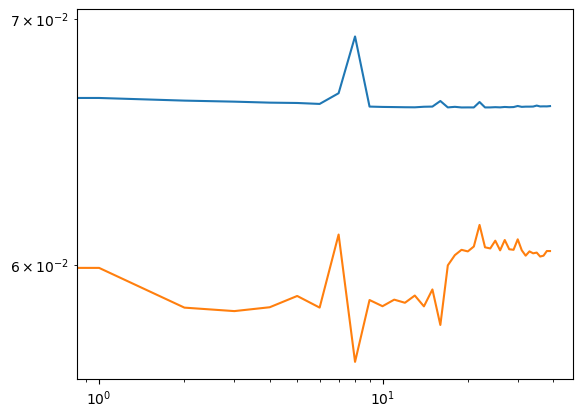

In [40]:
# Plot the learning curves (the evolution of the following quantities during training)
if not skip_training:
    fig, ax = plt.subplots(1)
    ax.loglog(train_errors)
    ax.loglog(val_errors)

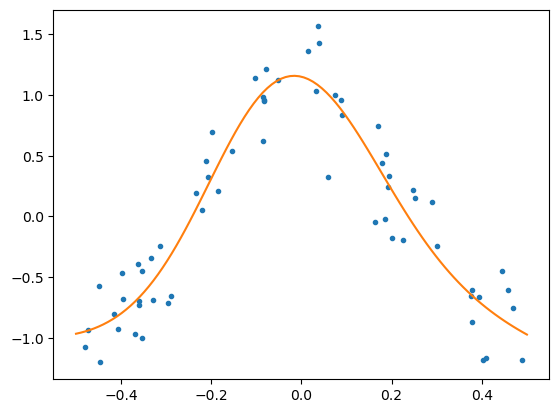

In [41]:
# Plot the final fit
plot_fit(mlp, x_train, y_train)

In [42]:
test_loss_weight_decay = compute_loss(mlp, x_test, y_test)
print("Test loss with weight decay: %.5f" % test_loss_weight_decay)
assert test_loss_weight_decay < 0.11

Test loss with weight decay: 0.06051


## Injecting noise to inputs

One way to improve generalization is to add noise to the inputs. So, we update the parameters of $f$ using the gradient of the following function
$$c= \sum_{i=1}^n || f(x_i + n_i) - y_i ||^2$$
where $n_i$ is a noise instance.

In the code below, implement adding Gaussian noise with standard deviation to the given inputs.

In [62]:
def add_noise(x, noise_std):
    """Add Gaussian noise to a PyTorch tensor.

    Args:
      x (tensor): PyTorch tensor of inputs.
      noise_std (float): Standard deviation of the Gaussian noise.

    Returns:
      x: Tensor with Gaussian noise added.
    """
    noise_std=np.random.normal(scale=noise_std,size=x.shape)
    return torch.tensor(noise_std).float()+x

In [63]:
# Let's test shapes
x = torch.randn(10)
x_with_noise = add_noise(x, 0.5)
assert x_with_noise.shape == x.shape, f"Bad x_with_noise.shape: {x_with_noise.shape}"

In [64]:
mlp = MLP()
mlp.to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.01)

In [65]:
# Train MLP with injecting noise to inputs
if not skip_training:
    n_epochs = 4000
    train_errors = []
    val_errors = []
    x = x_train.to(device)
    y = y_train.to(device)

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        outputs = mlp.forward(add_noise(x, noise_std=0.05))
        loss = F.mse_loss(outputs, y)
        loss.backward()
        optimizer.step()

        if (epoch+1) % 100 == 0:
            train_errors.append(compute_loss(mlp, x_train, y_train))
            val_errors.append(compute_loss(mlp, x_test, y_test))
            print_progress(epoch, train_errors[-1], val_errors[-1])

    # Save the model to disk (the pth-files will be submitted automatically together with your notebook)
    tools.save_model(mlp, 'mlp_noiseinj.pth', confirm=False)
else:
    mlp = MLP()
    tools.load_model(mlp, 'mlp_noiseinj.pth', device)

Epoch 99: Train error: 0.0760, Test error: 0.0850
Epoch 199: Train error: 0.0702, Test error: 0.0793
Epoch 299: Train error: 0.0693, Test error: 0.0848
Epoch 399: Train error: 0.0683, Test error: 0.0653
Epoch 499: Train error: 0.0669, Test error: 0.0754
Epoch 599: Train error: 0.0632, Test error: 0.0761
Epoch 699: Train error: 0.0635, Test error: 0.0819
Epoch 799: Train error: 0.0617, Test error: 0.0701
Epoch 899: Train error: 0.0678, Test error: 0.0862
Epoch 999: Train error: 0.0649, Test error: 0.0804
Epoch 1099: Train error: 0.0669, Test error: 0.0759
Epoch 1199: Train error: 0.0709, Test error: 0.0758
Epoch 1299: Train error: 0.0677, Test error: 0.0740
Epoch 1399: Train error: 0.0646, Test error: 0.0688
Epoch 1499: Train error: 0.0644, Test error: 0.0711
Epoch 1599: Train error: 0.0725, Test error: 0.0685
Epoch 1699: Train error: 0.0668, Test error: 0.0829
Epoch 1799: Train error: 0.0636, Test error: 0.0715
Epoch 1899: Train error: 0.0659, Test error: 0.0721
Epoch 1999: Train error

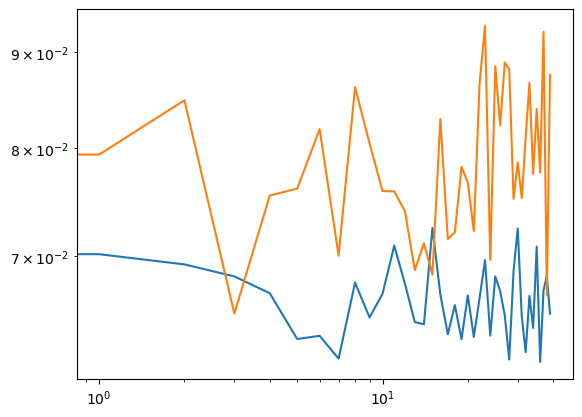

In [66]:
# Plot the learning curves
if not skip_training:
    fig, ax = plt.subplots(1)
    ax.loglog(train_errors)
    ax.loglog(val_errors)

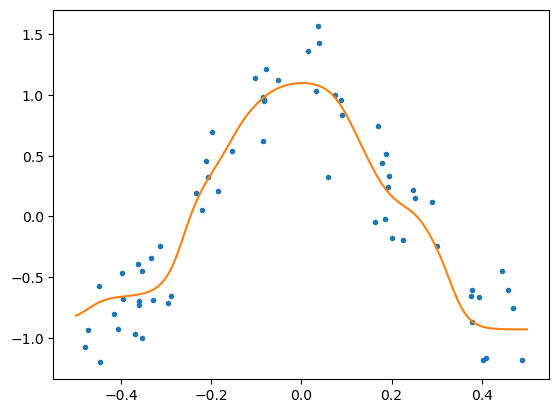

In [67]:
# Plot the final fit
plot_fit(mlp, x_train, y_train)

In [68]:
# Let's look at the test loss
test_loss_inj_noise = compute_loss(mlp, x_test, y_test)
print("Test loss with noise injection: %.5f" % test_loss_inj_noise)
assert test_loss_inj_noise < 0.13
assert optimizer.defaults['weight_decay'] == 0

Test loss with noise injection: 0.08750


## Dropout

Another way to improve generalization is to use dropout. In the cell below, define an MLP with exactly the same architecture as previously but with using `nn.Dropout` layers (with dropout probability 0.2) after each `tanh`
nonlinearity. 

In [73]:
class MLPDropout(nn.Module):
    def __init__(self):
        super(MLPDropout,self).__init__()
        self.fc1=nn.Linear(1,100)
        self.fc2=nn.Linear(100,100)
        self.fc3=nn.Linear(100,1)
        self.dropout1=nn.Dropout(p=.2)
        self.dropout2=nn.Dropout(p=.2)
        
    def forward(self, x):
        out=F.tanh(self.fc1(x))
        out=self.dropout1(out)
        out=F.tanh(self.fc2(out))
        out=self.dropout2(out)
        return self.fc3(out)

In [74]:
mlp = MLPDropout()
print(mlp)

MLPDropout(
  (fc1): Linear(in_features=1, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=1, bias=True)
  (dropout1): Dropout(p=0.2, inplace=False)
  (dropout2): Dropout(p=0.2, inplace=False)
)


In [75]:
mlp = MLPDropout()
mlp.to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.01)

In [76]:
# Train MLP with dropout
if not skip_training:
    #scheduler = StepLR(optimizer, step_size=100, gamma=0.95)
    n_epochs = 4000
    train_errors = []
    val_errors = []

    x = x_train.to(device)
    y = y_train.to(device)

    for epoch in range(n_epochs):
        #scheduler.step()
        mlp.train()
        optimizer.zero_grad()
        outputs = mlp.forward(x)
        loss = F.mse_loss(outputs, y)
        loss.backward()
        optimizer.step()

        if (epoch+1) % 100 == 0:
            mlp.eval()
            train_errors.append(compute_loss(mlp, x_train, y_train))
            val_errors.append(compute_loss(mlp, x_test, y_test))
            print_progress(epoch, train_errors[-1], val_errors[-1])

    # Save the model to disk (the pth-files will be submitted automatically together with your notebook)
    tools.save_model(mlp, 'mlp_dropout.pth', confirm=False)
else:
    mlp = MLPDropout()
    tools.load_model(mlp, 'mlp_dropout.pth', device)

Epoch 99: Train error: 0.0727, Test error: 0.0724
Epoch 199: Train error: 0.0731, Test error: 0.0858
Epoch 299: Train error: 0.0689, Test error: 0.0811
Epoch 399: Train error: 0.0690, Test error: 0.0849
Epoch 499: Train error: 0.0722, Test error: 0.0765
Epoch 599: Train error: 0.0702, Test error: 0.0846
Epoch 699: Train error: 0.0660, Test error: 0.0856
Epoch 799: Train error: 0.0689, Test error: 0.0777
Epoch 899: Train error: 0.0711, Test error: 0.0902
Epoch 999: Train error: 0.0682, Test error: 0.0849
Epoch 1099: Train error: 0.0685, Test error: 0.0777
Epoch 1199: Train error: 0.0664, Test error: 0.0817
Epoch 1299: Train error: 0.0658, Test error: 0.0819
Epoch 1399: Train error: 0.0658, Test error: 0.0787
Epoch 1499: Train error: 0.0623, Test error: 0.0834
Epoch 1599: Train error: 0.0623, Test error: 0.0754
Epoch 1699: Train error: 0.0624, Test error: 0.0735
Epoch 1799: Train error: 0.0624, Test error: 0.0767
Epoch 1899: Train error: 0.0716, Test error: 0.0810
Epoch 1999: Train error

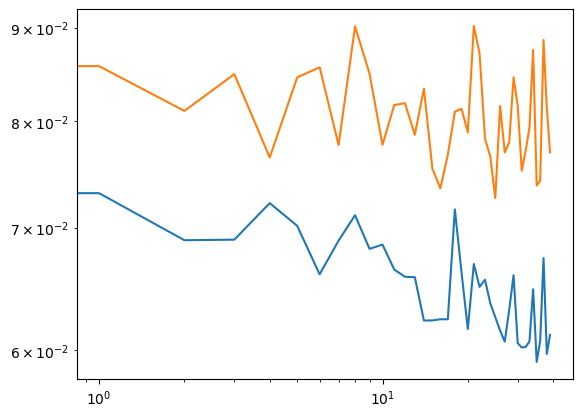

In [77]:
# Plot the learning curves
if not skip_training:
    fig, ax = plt.subplots(1)
    ax.loglog(train_errors)
    ax.loglog(val_errors)

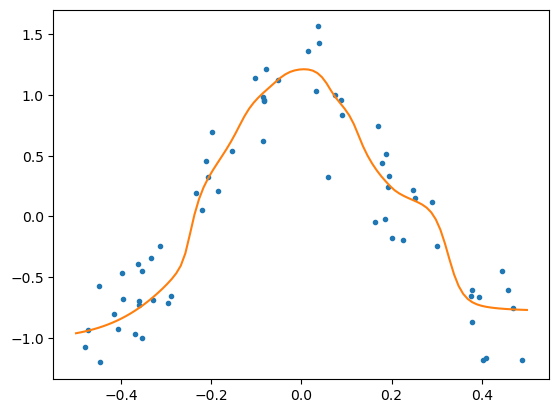

In [78]:
# Plot the final fit
mlp.eval()
plot_fit(mlp, x_train, y_train)

In [79]:
# Let's look at the test loss
test_loss_dropout = compute_loss(mlp, x_test, y_test)
print("Test loss with dropout: %.5f" % test_loss_dropout)
assert test_loss_dropout < 0.13
assert optimizer.defaults['weight_decay'] == 0

Test loss with dropout: 0.07695


## Reducing model capacity

Another simple way to reduce overfitting is to reduce the capacity of the model. Let us use for the same regression task a much smaller network: an MLP with one hidden layer with five units, tanh nonlinearity in the hidden layer and a linear output layer.

In [82]:
class MLPSmall(nn.Module):
    def __init__(self):
        super(MLPSmall, self).__init__()
        self.fc1=nn.Linear(1,5)
        self.fc2=nn.Linear(5,1)

    def forward(self, x):
        x=F.tanh(self.fc1(x))
        return self.fc2(x)

In [83]:
mlp = MLPSmall()
mlp.to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=0.001)

In [84]:
if not skip_training:
    n_epochs = 10000
    train_errors = []  # Keep track of the training data
    val_errors = []  # Keep track of the validation data

    x = x_train.to(device)
    y = y_train.to(device)

    for epoch in range(n_epochs):
        optimizer.zero_grad()
        outputs = mlp.forward(x)
        loss = F.mse_loss(outputs, y)
        loss.backward()
        optimizer.step()

        if (epoch+1) % 500 == 0:
            train_errors.append(compute_loss(mlp, x_train, y_train))
            val_errors.append(compute_loss(mlp, x_test, y_test))
            print_progress(epoch, train_errors[-1], val_errors[-1])

    # Save the model to disk (the pth-files will be submitted automatically together with your notebook)
    tools.save_model(mlp, 'mlp_small.pth', confirm=False)
else:
    mlp = MLPSmall()
    tools.load_model(mlp, 'mlp_small.pth', device)

Epoch 499: Train error: 0.5468, Test error: 0.5305
Epoch 999: Train error: 0.3691, Test error: 0.3391
Epoch 1499: Train error: 0.1651, Test error: 0.1326
Epoch 1999: Train error: 0.0942, Test error: 0.0690
Epoch 2499: Train error: 0.0796, Test error: 0.0587
Epoch 2999: Train error: 0.0740, Test error: 0.0554
Epoch 3499: Train error: 0.0708, Test error: 0.0541
Epoch 3999: Train error: 0.0688, Test error: 0.0539
Epoch 4499: Train error: 0.0676, Test error: 0.0545
Epoch 4999: Train error: 0.0668, Test error: 0.0557
Epoch 5499: Train error: 0.0665, Test error: 0.0570
Epoch 5999: Train error: 0.0663, Test error: 0.0583
Epoch 6499: Train error: 0.0662, Test error: 0.0593
Epoch 6999: Train error: 0.0662, Test error: 0.0600
Epoch 7499: Train error: 0.0661, Test error: 0.0605
Epoch 7999: Train error: 0.0661, Test error: 0.0608
Epoch 8499: Train error: 0.0661, Test error: 0.0610
Epoch 8999: Train error: 0.0661, Test error: 0.0611
Epoch 9499: Train error: 0.0661, Test error: 0.0611
Epoch 9999: Tr

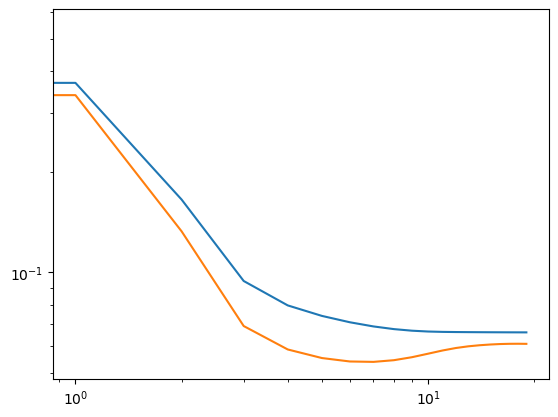

In [85]:
# Plot the learning curves
if not skip_training:
    fig, ax = plt.subplots(1)
    ax.loglog(train_errors)
    ax.loglog(val_errors)

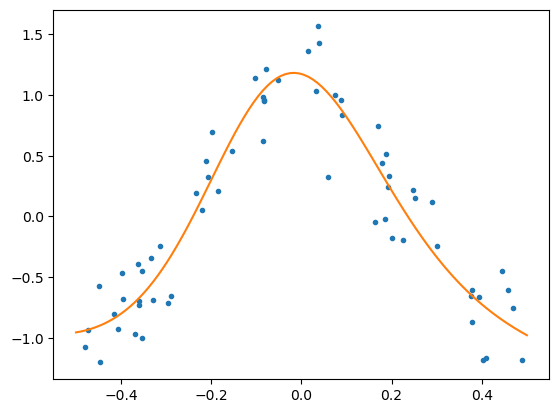

In [86]:
# Plot the final fit
mlp.eval()
plot_fit(mlp, x_train, y_train)

In [87]:
# Let's look at the test loss
test_loss_small = compute_loss(mlp, x_test, y_test)
print("Test loss by reducing model capacity: %.5f" % test_loss_small)
assert test_loss_small < 0.11
assert optimizer.defaults['weight_decay'] == 0

Test loss by reducing model capacity: 0.06105


In [88]:
# We can summarize the results obtained with different regularization methods:
print('No regularization: %.5f' % test_loss_no_regularization)
print('Early stopping:    %.5f' % test_loss_early_stopping)
print('Weight decay:      %.5f' % test_loss_weight_decay)
print('Noise injection:   %.5f' % test_loss_inj_noise)
print('Dropout:           %.5f' % test_loss_dropout)
print('Small network:     %.5f' % test_loss_small)

No regularization: 0.14255
Early stopping:    0.06394
Weight decay:      0.06051
Noise injection:   0.08750
Dropout:           0.07695
Small network:     0.06105


The values of the hyperparameters (parameters of the training procedure) may have major impact on the results. One has to find the best hyperparameter values which is usually done by measuring the performance on the validation set.